<a href="https://colab.research.google.com/github/sdgroeve/D012554_Machine_Learning_2023/blob/main/01_pytorch_workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

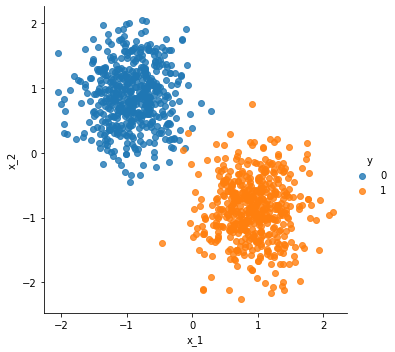

In [95]:
#creating the dataset

from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
import pandas as pd
import seaborn as sns

X, y = make_blobs(n_samples=1000, centers=2, cluster_std=2, n_features=2, random_state=9)

X = StandardScaler().fit_transform(X)

tmp = pd.DataFrame(X,columns=["x_1","x_2"])
tmp["y"] = y

sns.lmplot(x="x_1",y="x_2",hue="y",data=tmp,fit_reg=False)

tmp.to_csv("dataset_logistic_regression.csv",index=False)


In [96]:
!pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# 1. A basic workflow


[PyTorch](https://pytorch.org/) is an open source deep learning framework. 

In this notebook we will learn about a PyTorch training and evaluation workflow for fitting a logistic regression model on a toy dataset.

First we import the required PyTorch libraries and fix the random seed.

In [97]:
import torch
from torch import nn 

torch.manual_seed(46)

# Check PyTorch version
torch.__version__

'1.13.1+cu116'

A tyical PyTorch workflow involves:

1. Preparing the data
2. Building the model
3. Fitting the model to the data (training)
4. Computing predictions and evaluating the model
5. Saving the model

Let's discuss these steps in more detail by fitting a logistic regression model.

## 1. Preparing the data

The dataset is in a flat file called `dataset_logistic_regression.csv`. 

We read this file into a Pandas DataFrame.

In [98]:
import pandas as pd

dataset = pd.read_csv("dataset_logistic_regression.csv")

dataset.head()

,x_1,x_2,y
0,-1.385532,0.930333,0
1,0.470672,-0.645184,1
2,1.109673,-0.775433,1
3,-0.921845,0.623731,0
4,1.625524,-0.874740,1


The dataset as two features `x_1` and `x_2`, and one label `y`. 

Let's plot this data. 

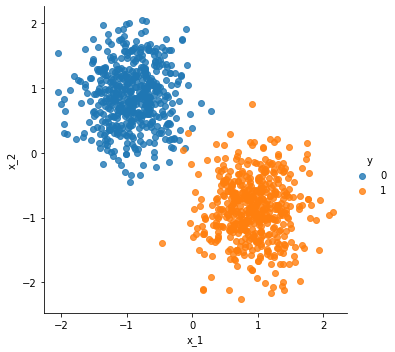

In [99]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.lmplot(x="x_1",y="x_2",hue="y",data=dataset,fit_reg=False)
plt.show()

We put the feature columns in a DataFrame called `X` and the label column in a DataFrame called `y`.

In [100]:
y = dataset.pop('y')
X = dataset

A typical deep learning workflow would involve a train, a validation and a test split of the dataset.

Each split serves a specific purpose:

| Split | Purpose | Amount of total data | How often is it used? |
| ----- | ----- | ----- | ----- |
| **train set** | The model learns from this data. | ~60-80% | Always |
| **validation set** | The model gets tuned on this data. | ~10-20% | Often but not always |
| **test set** | The model gets evaluated on this data to test what it has learned. | ~10-20% | Always |

In [101]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(800, 2)
(100, 2)
(100, 2)


In PyTorch we work with Tensor representaions of the dataset. A PyTorch Tensor is basically the same as a numpy array: it does not know anything about deep learning or computational graphs or gradients, and is just a generic n-dimensional array to be used for arbitrary numeric computation.

To create a Tensor we need to first extract the NumPy data from the Pandas DataFrames.

In [103]:
X_train, X_val, X_test = X_train.values, X_val.values, X_test.values
y_train, y_val, y_test = y_train.values, y_val.values, y_test.values

In [104]:
X_train

array([[-1.09364013,  0.25510156],
       [-0.78469195,  0.91051752],
       [ 1.06057683, -0.91358588],
       ...,
       [ 0.96704068, -1.34136883],
       [ 0.89388643, -0.85085827],
       [-1.33275052,  0.3117806 ]])

Now we can create the Tensors.

In [105]:
X_train, X_val, X_test = torch.Tensor(X_train),torch.Tensor(X_val),torch.Tensor(X_test)
y_train, y_val, y_test = torch.Tensor(y_train),torch.Tensor(y_val),torch.Tensor(y_test)

## 2. Building the model

To build a model in PyTorch we need to create a subclass of `torch.nn.Module` such that this subclass inherits all functionality required for fitting our model.

In [106]:
class LogisticRegression(torch.nn.Module):
  def __init__(self, input_dim, output_dim):
    super(LogisticRegression, self).__init__()
    #our model has just one linear layer
    self.linear = torch.nn.Linear(input_dim, output_dim)   
    #the modelparameters are initialized at random
    torch.nn.init.uniform_(self.linear.weight) 
  def forward(self, x):
    #the output is a linear function of the features followed by the sigmoid function
    outputs = torch.sigmoid(self.linear(x))
    return outputs

For our model class `LogisticRegression()` we need to define at least two methods: `__init__()` and `forward()`.

### `__init()__`

The method `__init__()` is called when an instance of our class `LogisticRegression` is created. This is done in the following code.

In [107]:
# Two inputs x_1 and x_2
input_dim = 2  
# Single binary output 
output_dim = 1 

# Create an instance of the model (this is a subclass of nn.Module that contains nn.Parameter(s))
model = LogisticRegression(input_dim, output_dim)

This code created a linear model with two modelparameters that each have a random value. 

Because we inherit all functionality of the `totch.nn.Module` class we can now, for instance, call the inherited `.state_dict()` method to get the state (what the model contains) of the model.

In [108]:
model.state_dict()

OrderedDict([('linear.weight', tensor([[0.1596, 0.7550]])),
             ('linear.bias', tensor([0.0246]))])

### `forward()`

When we pass data to our model, it'll go through the model's `forward()` method and produce a result using the computation we've defined. 

Let's make some predictions for the first 10 feature vectors in the test set.

In [110]:
with torch.inference_mode(): 
    predictions = model(X_test[:10])

predictions

tensor([[0.4206],
        [0.6524],
        [0.5636],
        [0.5938],
        [0.7445],
        [0.5785],
        [0.3637],
        [0.4000],
        [0.5141],
        [0.6127]])

Because we are working with Tensors the model outputs an array of (1-dimensional) arrays.

In [111]:
predictions.shape

torch.Size([10, 1])

We use the PyTorch method `squeeze()` to reshape this Tensor to a 1-dimensional array.

In [112]:
predictions = torch.squeeze(predictions)

predictions

tensor([0.4206, 0.6524, 0.5636, 0.5938, 0.7445, 0.5785, 0.3637, 0.4000, 0.5141,
        0.6127])

As with the Pandas example above, we can extract the data as a NumPy array.

In [113]:
predictions = predictions.detach().numpy()

predictions

array([0.4205827 , 0.65236455, 0.56362563, 0.5938149 , 0.74452406,
       0.578528  , 0.36368713, 0.39997375, 0.5141345 , 0.6127332 ],
      dtype=float32)

The Tansor.detach() method is used to detach a tensor from the current computational graph (more about this later). 

We also need to detach a tensor when we need to move the tensor from GPU to CPU.

Now we can compute evaluation metrics for the predicitons, e.g. the AUC.

In [114]:
from sklearn.metrics import roc_auc_score

with torch.inference_mode(): 
    predictions = model(X_test)

predictions = torch.squeeze(predictions)
predictions = predictions.detach().numpy()

print("test set AUC: {}".format(roc_auc_score(y_test,predictions)))

test set AUC: 0.023752012882447666


You probably noticed we used [`torch.inference_mode()`](https://pytorch.org/docs/stable/generated/torch.inference_mode.html) as a [context manager](https://realpython.com/python-with-statement/) (that's what the `with torch.inference_mode():` is) to make the predictions.

As the name suggests, `torch.inference_mode()` is used when using a model for inference (making predictions).

`torch.inference_mode()` turns off a bunch of things (like gradient tracking, which is necessary for training but not for inference) to make **forward-passes** (data going through the `forward()` method) faster.

## 3. Train the model

Our model is making predictions using random modelparameter values.


For our model to update its parameters on its own, we'll need to add a few more things to our recipe.

To train the model we need to add a **loss function** and an **optimizer**. The loss function measures how wrong the model predictions are compared to the true labels. The optimizer tells your model how to update its modelparameters to best lower the loss.

Let's create a loss function and an optimizer we can use to help improve our model.

Depending on what kind of problem you're working on will depend on what loss function and what optimizer you use.

However, there are some common values, that are known to work well such as the SGD (stochastic gradient descent) or Adam optimizer. And the MAE (mean absolute error) loss function for regression problems or cross entropy loss function for classification problems, as for our dataset. 

For the optimizer we will SGD, `torch.optim.SGD(params, lr)` where:

* `params` are the modelparameters we want to optimize
* `lr` is the **learning rate** you'd like the optimizer to update the modelparameters at

In [115]:
learning_rate = 0.001

#the loss function
loss_func = torch.nn.CrossEntropyLoss()

#the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

Now we've got a loss function and an optimizer, it's now time to create a **training loop** (and **validation loop**).

For the training loop, we have to code the following steps:

1. Forward pass: the model goes through all of the training data once, performing its `forward()` function calculations.

2. Calculate the loss: the model's outputs (predictions) are compared to the ground truth and evaluated to see how wrong they are.
3. Zero the gradients: the optimizers gradients are set to zero (they are accumulated by default) so they can be recalculated for the specific training step.
4. Perform backpropagation on the loss: computes the gradient of the loss with respect to every modelparameter 
5. Update the optimizer (**gradient descent**): update the modelparameter values with respect to the loss gradients.


training loss: 2673.524658203125


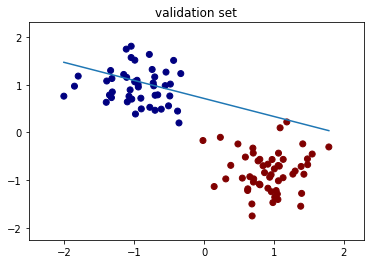

validation AUC: 0.07407407407407407
training loss: 2657.168701171875


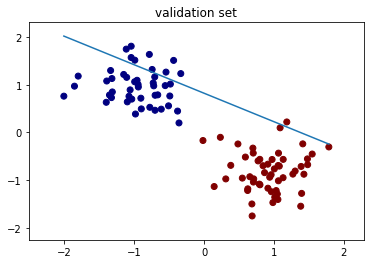

validation AUC: 0.21175523349436393
training loss: 2640.551513671875


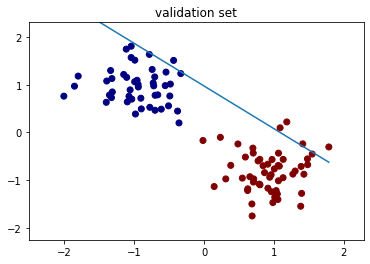

validation AUC: 0.4750402576489533
training loss: 2624.275146484375


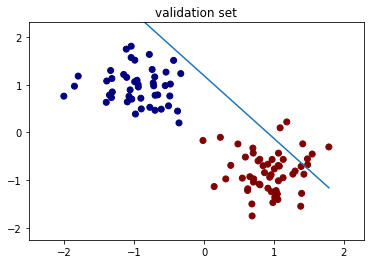

validation AUC: 0.7149758454106281
training loss: 2608.915283203125


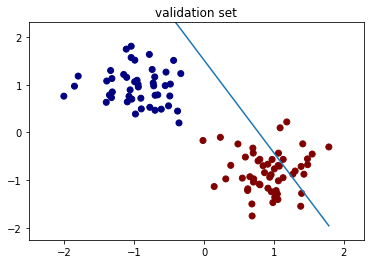

validation AUC: 0.8993558776167472
training loss: 2594.900634765625


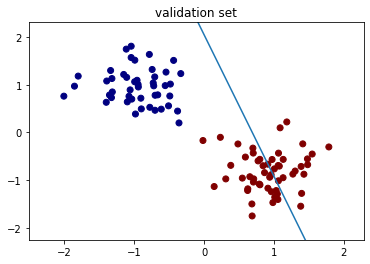

validation AUC: 0.9597423510466988
training loss: 2582.451416015625


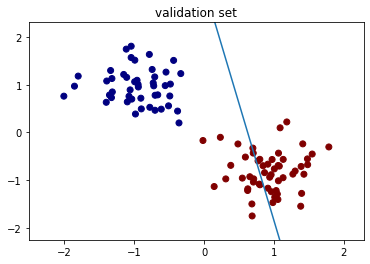

validation AUC: 0.9814814814814814
training loss: 2571.597412109375


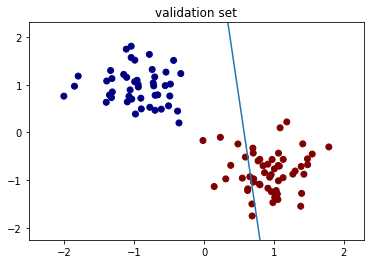

validation AUC: 0.9907407407407407
training loss: 2562.23388671875


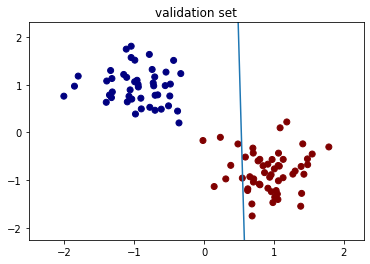

validation AUC: 1.0
training loss: 2554.192138671875


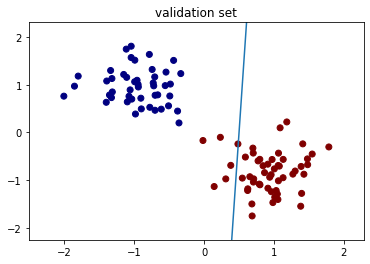

validation AUC: 1.0
training loss: 2547.28369140625


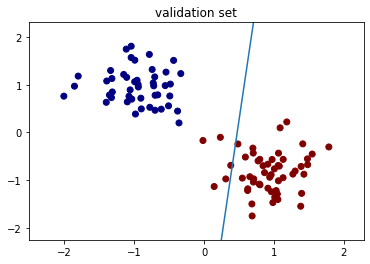

validation AUC: 1.0
training loss: 2541.32958984375


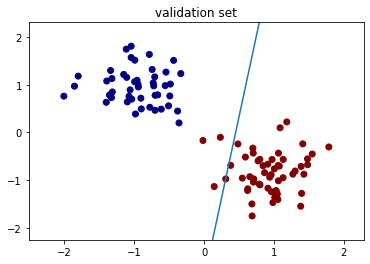

validation AUC: 1.0
training loss: 2536.173828125


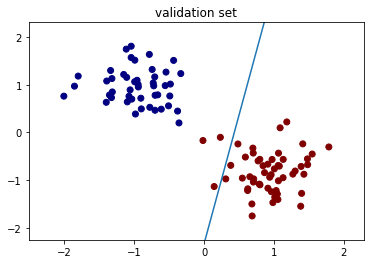

validation AUC: 1.0
training loss: 2531.682861328125


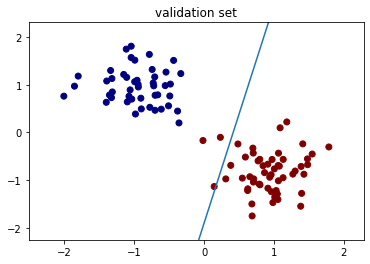

validation AUC: 1.0
training loss: 2527.74658203125


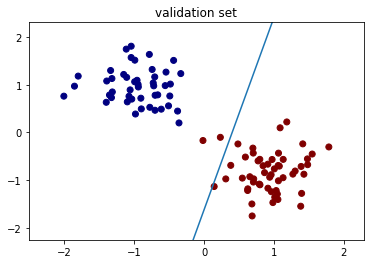

validation AUC: 1.0
training loss: 2524.2763671875


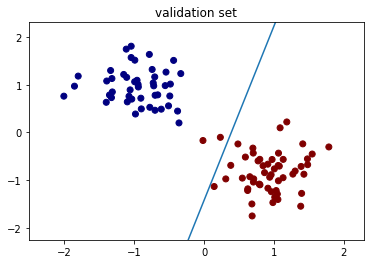

validation AUC: 1.0
training loss: 2521.1982421875


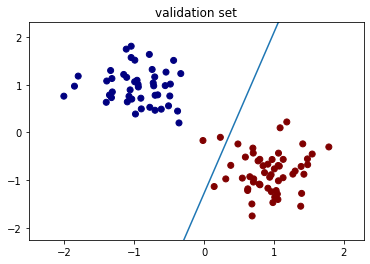

validation AUC: 1.0
training loss: 2518.45166015625


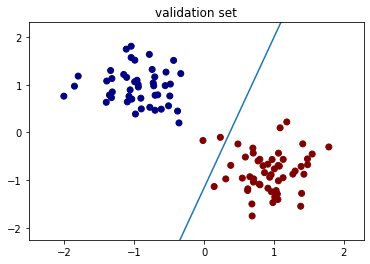

validation AUC: 1.0
training loss: 2515.98876953125


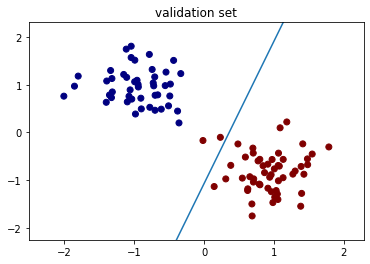

validation AUC: 1.0
training loss: 2513.768310546875


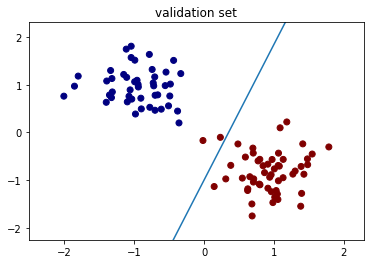

validation AUC: 1.0


In [116]:
#number of times we iterate trough the train set
num_epochs = 20

for epoch in range(num_epochs):

    #step 1
    predictions_train = torch.squeeze(model(X_train)) 

    #step 2
    loss = loss_func(predictions_train, y_train) 
    print("training loss: {}".format(loss))    

    #step 3
    optimizer.zero_grad() 

    #step 4
    loss.backward() 

    #step 5
    optimizer.step() # Updates weights and biases with the optimizer (SGD)
        
    #compute AUC on validation set
    predictions_val = torch.squeeze(model(X_val)).round().detach().numpy()
    print("validation AUC: {}".format(roc_auc_score(y_val,predictions_val)))

## 4. Computing predictions and evaluating the model


In [117]:
model.eval()

with torch.inference_mode(): 
    predictions_test = model(X_test)

predictions_test = torch.squeeze(predictions_test).detach().numpy()

print("test set AUC: {}".format(roc_auc_score(y_test,predictions_test)))

test set AUC: 0.998792270531401


## 5. Saving (and loading) the model

The [recommended way](https://pytorch.org/tutorials/beginner/saving_loading_models.html#saving-loading-model-for-inference) for saving a model for inference (making predictions) is by saving the modelparameter values in `state_dict()`.

We call `torch.save(obj, f)` where `obj` is the target model's `state_dict()` and `f` is the filename of where to save the model.

It's common convention for PyTorch saved models or objects to end with `.pt` or `.pth`, like `saved_model_01.pth`.


In [122]:
model_filename = "model_logistic_regression.pth"
torch.save(obj=model.state_dict(), f=model_filename) 

To load a model, we first load the `state_dict()` with `torch.load()` and then pass that `state_dict()` to a new instance of our model (which is a subclass of `nn.Module`).


In [123]:
# Instantiate a new instance of our model (this will be instantiated with random weights)
loaded_model = LogisticRegression(input_dim, output_dim)

# Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
loaded_model.load_state_dict(torch.load(f=model_filename))

<All keys matched successfully>

Excellent! It looks like things matched up.

Now to test our loaded model, let's perform inference with it (make predictions) on the test data.

Remember the rules for performing inference with PyTorch models?

If not, here's a refresher:

<details>
    <summary>PyTorch inference rules</summary>
    <ol>
      <li> Set the model in evaluation mode (<code>model.eval()</code>). </li>
      <li> Make the predictions using the inference mode context manager (<code>with torch.inference_mode(): ...</code>). </li>
      <li> All predictions should be made with objects on the same device (e.g. data and model on GPU only or data and model on CPU only).</li>
    </ol> 
</details>



In [124]:
# 1. Put the loaded model into evaluation mode
loaded_model.eval()

# 2. Use the inference mode context manager to make predictions
with torch.inference_mode():
    loaded_model_preds = loaded_model(X_test) # perform a forward pass on the test data with the loaded model